<a href="https://colab.research.google.com/github/Buchunwang/UK-CLI/blob/main/K%26N_(1998)_algorithm_with_UK_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre.csv'
print('From URL:', url)
kalpre = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)

From URL: https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre.csv


In [5]:

import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
scale= StandardScaler()
kalpre = scale.fit_transform(kalpre)

N = 421 #length of input
Y = np.transpose(kalpre[:,3:9])#Y_{1t} to Y_{5t}
# Calculate delta_y, delta_y_t-1, and delta_y_t-2
# Yit-E(Y), remove the mean value
y = np.zeros((5, N))
y1lag = np.zeros((5, N))
y2lag = np.zeros((5, N))
for i in range(5):
    y[i-1, :] = kalpre[:, i + 2] - np.mean(kalpre[:, i + 2])
    y1lag[i-1, :] = kalpre[:, i + 7] - np.mean(kalpre[:, i + 7])
    y2lag[i-1, :] = kalpre[:, i + 12] - np.mean(kalpre[:, i + 12])
x = np.zeros((3, N))#empty matrix to save mean value of xi_t


Q_kal = np.array([[1, 0, 0],
[0, 1, 0],
[0, 0, 0]])
#Q in kalman filter, process noise, we rename it as Q_kal
# to avoid repeated use of Q in Gibbs sampling
phi=np.zeros(2)
psi=np.zeros((5,2))

x = np.zeros((3, N))#empty matrix to save mean value of xi_t
vct = np.zeros((3, N))#empty matrix to save variance of xi_t

var_vt=1

mu_st=np.zeros(N) #this is for kalman filter

######################################################
# The following settings are for estimation of parameters in after hmailton basic filter
iter = 10000 # number of iterations
burn = 2000 #we burn the first 2000 iterations and sampling from the later 8000 iterations in the Monter Carlo
#Now we begin to set the initial values of parameters wwe are going to estimate in the algorithm

# As this code is a mixture of three independent code, unavoidabely there are repeated variables
#such as N, to avoid troubles (as N used in too many places), we will modify the value of N in the loop
N=419

phi_1 = np.random.normal(0, 1, (N - 4, 1))
phi_2 = np.random.normal(0, 1, (N - 4, 1))
lamda_1 = np.random.normal(0, 1, (N, 1))
#these are just initial settings,
#later on we will draw samples of thses parameters by newly generated mean and variance (or other distribution parameters for other types of distribution)
lamda_2 = np.random.normal(0, 1, (N, 1))
lamda_3 = np.random.normal(0, 1, (N, 1))
lamda_4 = np.random.normal(0, 1, (N, 1))
lamda_5 = np.random.normal(0, 1, (N, 1))
Psi1 = np.random.normal(0, 1, (N - 2, 2))
Psi2 = np.random.normal(0, 1, (N - 2, 2))
Psi3 = np.random.normal(0, 1, (N - 2, 2))
Psi4 = np.random.normal(0, 1, (N - 2, 2))
Psi5 = np.random.normal(0, 1, (N - 2, 2))
rrighta3 = np.zeros((1, N - 2))#this matrix is for calculating distribution of lamda
q = np.random.binomial(0.9, 0.066)
p = np.random.binomial(0.967, 0.032)
sig1 = 0.2 #initial value of sigma_i
sig2 = 0.2
sig3 = 0.2
sig4 = 0.2
sig5 = 0.2
St=np.zeros((N,1))
mu0 = np.random.normal(0, 1, (N - 2, 1))
mu1 = np.random.normal(0, 1, (N - 2, 1))
mut = mu0 + mu1 * St[2:N] #corresponding regime for t=3 to N, this is for estimating parameters


# variance and mean initial set
varlamda1 = 1
varlamda2 = 1
varlamda3 = 1
varlamda4 = 1
varlamda5 = 1
meanlamda1 = 0 #lamda_1~N(meanlamda1,varlamda1)
meanlamda2 = 0
meanlamda3 = 0
meanlamda4 = 0
meanlamda5 = 0
varpsi1 = np.eye(2)
varpsi2 = np.eye(2)
varpsi3 = np.eye(2)
varpsi4 = np.eye(2)
varpsi5 = np.eye(2)
meanpsi1 = np.zeros((2, 1))#psi_1~N(meanpsi1,varpsi1), meanpsi1=np.array([[a],[b]]),varpsii1=np.array([[a1,a2],[b1,b2]])
meanpsi2 = np.zeros((2, 1))
meanpsi3 = np.zeros((2, 1))
meanpsi4 = np.zeros((2, 1))
meanpsi5 = np.zeros((2, 1))
sig1a = 4 + N / 2 #sigma_1~IG(sig1a,sig1b) inverse gamma distribution
sig2a = 4 + N / 2
sig3a = 4 + N / 2
sig4a = 4 + N / 2
sig5a = 4 + N / 2
sig1b = 4
sig2b = 4
sig3b = 4
sig4b = 4
sig5b = 4
X1 = np.zeros((N - 2, 2))
X2 = np.zeros((N - 2, 2))
X3 = np.zeros((N - 2, 2))
X4 = np.zeros((N - 2, 2))
X5 = np.zeros((N - 2, 2))
varphi = np.array([[1, 0], [0, 1]])
meanphi = np.array([0, 0])
varmu = np.array([[1, 0], [0, 1]])
meanmu = np.array([[0], [0]])
Q = np.zeros((N - 4, 2))
Qstar = np.zeros((N - 4, 2))

# Output
# We set some empty matrices here to save values from each iteration
# After the 2000 burn-in period, we need to save value for later 80000 iterations
mlamda1 = np.zeros(8000)
mlamda2 = np.zeros(8000)
mlamda3 = np.zeros(8000)
mlamda4 = np.zeros(8000)
mlamda5 = np.zeros(8000)
vlamda1 = np.zeros(8000)
vlamda2 = np.zeros(8000)
vlamda3 = np.zeros(8000)
vlamda4 = np.zeros(8000)
vlamda5 = np.zeros(8000)
bsig1 = np.zeros(8000)
bsig2 = np.zeros(8000)
bsig3 = np.zeros(8000)
bsig4 = np.zeros(8000)
bsig5 = np.zeros(8000)
mpsi11 = np.zeros(8000)
mpsi21 = np.zeros(8000)
mpsi31 = np.zeros(8000)
mpsi41 = np.zeros(8000)
mpsi12 = np.zeros(8000)
mpsi22 = np.zeros(8000)
mpsi32 = np.zeros(8000)
mpsi42 = np.zeros(8000)
mpsi51 = np.zeros(8000)
mpsi52 = np.zeros(8000)
vpsi11 = np.zeros(8000)
vpsi21 = np.zeros(8000)
vpsi31 = np.zeros(8000)
vpsi41 = np.zeros(8000)
vpsi12 = np.zeros(8000)
vpsi22 = np.zeros(8000)
vpsi32 = np.zeros(8000)
vpsi42 = np.zeros(8000)
vpsi51 = np.zeros(8000)
vpsi52 = np.zeros(8000)
mphi1 = np.zeros(8000)
mphi2 = np.zeros(8000)
vphi1 = np.zeros(8000)
vphi2 = np.zeros(8000)
mmu1 = np.zeros(8000)
mmu2 = np.zeros(8000)
vmu1 = np.zeros(8000)
vmu2 = np.zeros(8000)
sig1 = np.sqrt(1 / np.random.gamma(sig1a, 1 / sig1b))
sig2 = np.sqrt(1 / np.random.gamma(sig2a, 1 / sig2b))
sig3 = np.sqrt(1 / np.random.gamma(sig3a, 1 / sig3b))
sig4 = np.sqrt(1 / np.random.gamma(sig4a, 1 / sig4b))
sig5 = np.sqrt(1 / np.random.gamma(sig5a, 1 / sig5b))
transition_prob_p=np.zeros(8000)
transition_prob_q=np.zeros(8000)
delta=np.zeros(8000)
# Initialize the DataFrame with the size of 8x419 with NaNs
inputkal1 = pd.DataFrame(np.nan, index=range(419), columns=range(8))
N=421
St=np.zeros(N) # as we are starting from kalman filter, St for kalman filter is 421
SSt=np.zeros(N)
delta_y_mean = np.zeros((5,1))
for i in range(5):
    delta_y_mean[i-1,0] = np.mean(kalpre[:, i + 2]) #used in generating delta in appendix 7
E=np.array([1,0,0]) #used in generating delta in appendix 7


In [10]:
from numpy.random import normal
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma, beta
import warnings

# Define a custom warning handler that discards the warnings
def custom_warning_handler(*args, **kwargs):
    pass

# Replace the default warning handler with the custom handler
warnings.showwarning = custom_warning_handler

##############################################################################
#iter = 1000 # number of iterations
#burn = 200
#small iteration for tests
#Start iteration here
for i in range(iter):

# First part of MCMC------- Kalman Filter


##############################

    N=kalpre.shape[0]   # length of data
# Use the parameters from last iteration
# we need new A,R,H
#    R = np.array([
#                 [sig1, 0, 0, 0, 0],
#                 [0, sig2, 0, 0, 0],
#                 [0, 0, sig3, 0, 0],
#                 [0, 0, 0, sig4, 0],
#                 [0, 0, 0, 0, sig5]
#                 ])
    R = np.array([[sig1.item(), 0, 0, 0, 0],
              [0, sig2.item(), 0, 0, 0],
              [0, 0, sig3.item(), 0, 0],
              [0, 0, 0, sig4.item(), 0],
              [0, 0, 0, 0, sig5.item()]])

#observation noise, variance matrix of [epsilon 1,epsilon 2,epsilon 3,epsilon 4,epsilon 5]
    #R = np.array([[i[0][0] if isinstance(i, np.ndarray) else i for i in row] for row in R])

# variance sig_12345 are updated every iteration


    phi[0]=np.random.normal(meanphi[0], np.sqrt(varphi[0, 0]))
    phi[1]=np.random.normal(meanphi[1], np.sqrt(varphi[1, 1]))#new phi generated from last iteration
    A = np.array([[phi[0], phi[1], 0],
              [0, phi[0], phi[1]],
              [0, 1, 0]])
   #np.array([[phi1,phi2,0],
   #          [0,phi1,phi2],
   #          [0,  1,    0]])
   # generate new psi from last iteration
    psi[0,0]=np.random.normal(meanpsi1[0], np.sqrt(varpsi1[0, 0]))
    psi[0,1]=np.random.normal(meanpsi1[1], np.sqrt(varpsi1[1, 1]))
    psi[1,0]=np.random.normal(meanpsi2[0], np.sqrt(varpsi2[0, 0]))
    psi[1,1]=np.random.normal(meanpsi2[1], np.sqrt(varpsi2[1, 1]))
    psi[2,0]=np.random.normal(meanpsi3[0], np.sqrt(varpsi3[0, 0]))
    psi[2,1]=np.random.normal(meanpsi3[1], np.sqrt(varpsi3[1, 1]))
    psi[3,0]=np.random.normal(meanpsi4[0], np.sqrt(varpsi4[0, 0]))
    psi[3,1]=np.random.normal(meanpsi4[1], np.sqrt(varpsi4[1, 1]))
    psi[4,0]=np.random.normal(meanpsi5[0], np.sqrt(varpsi5[0, 0]))
    psi[4,1]=np.random.normal(meanpsi5[1], np.sqrt(varpsi5[1, 1]))


    H = np.array([
    [np.random.normal(meanlamda1, np.sqrt(varlamda1)), -np.random.normal(meanlamda1, np.sqrt(varlamda1)) * psi[0, 0], -np.random.normal(meanlamda1, np.sqrt(varlamda1)) * psi[0, 1]],
    [np.random.normal(meanlamda2, np.sqrt(varlamda2)), -np.random.normal(meanlamda2, np.sqrt(varlamda2)) * psi[1, 0], -np.random.normal(meanlamda2, np.sqrt(varlamda2)) * psi[1, 1]],
    [np.random.normal(meanlamda3, np.sqrt(varlamda3)), -np.random.normal(meanlamda3, np.sqrt(varlamda3)) * psi[2, 0], -np.random.normal(meanlamda3, np.sqrt(varlamda3)) * psi[2, 1]],
    [np.random.normal(meanlamda4, np.sqrt(varlamda4)), -np.random.normal(meanlamda4, np.sqrt(varlamda4)) * psi[3, 0], -np.random.normal(meanlamda4, np.sqrt(varlamda4)) * psi[3, 1]],
    [np.random.normal(meanlamda5, np.sqrt(varlamda5)), -np.random.normal(meanlamda5, np.sqrt(varlamda5)) * psi[4, 0], -np.random.normal(meanlamda5, np.sqrt(varlamda5)) * psi[4, 1]]
])
    H = np.squeeze(H)



#H = np.array([[lamda[0,0], -lamda[0,0]*psi[0, 0], -lamda[0,0]*psi[0, 1]],
#              [lamda[0,1], -lamda[0,1]*psi[1, 0], -lamda[0,1]*psi[1, 1]],
#             [lamda[0,2], -lamda[0,2]*psi[2, 0], -lamda[0,2]*psi[2, 1]],
#            [lamda[0,3], -lamda[0,3]*psi[3, 0], -lamda[0,3]*psi[3, 1]],
#           [lamda[0,4], -lamda[0,4]*psi[4, 0], -lamda[0,4]*psi[4, 1]]]) all lamda and psi come from random sampling from last iteration

    P = 0.1 * np.eye(3)# initial setting of variance matrix of xi_t
    z = np.ones((5, N))
# Construct delta_y* using new psi
    ystar = y.T - np.multiply(psi[:, 0].T, y1lag[0:5, :].T)- np.multiply(psi[:, 1].T,y2lag[0:5, :].T)
    ystar=ystar.T
    true5D = ystar
#form new mu_st
    St=SSt
    mu_st = np.random.normal(meanmu[0], np.sqrt(varmu[0,0]))*np.ones(N) + np.random.normal(meanmu[1], np.sqrt(varmu[1,1]))*np.ones(N) * St

    Mu_st=np.zeros((3,N))
    Mu_st[0,:]=mu_st
    Mu_st[1,1:N]=mu_st[0:N-1]

#start kalman filter
    k = 0
    for t in range(N-1):
        k += 1
        x[:, k] = np.dot(A, x[:, k-1])+Mu_st[:,k]    # Kalman equation 1
        P = np.dot(A, np.dot(P, A.T)) +Q_kal #np.dot(B,np.dot(Q,B.T))  # Kalman equation 2
        K = np.dot(P, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P, H.T)) + R)))  # Kalman equation 3
        z[:, k] = [true5D[0, k], true5D[1, k], true5D[2, k], true5D[3, k], true5D[4, k]]
        x[:, k] = x[:, k] + np.dot(K, (z[:, k] - np.dot(H, x[:, k])))  # Kalman equation 4
        P = np.dot((np.eye(3) - np.dot(K, H)), P)  # Kalman equation 5
        vct[0, k] = P[0, 0]  # save variance of delta_ct
        vct[1, k] = P[1, 1]
        vct[2, k] = P[2, 2]






###########################################################################
# add t+1 data to information set


    c = normal(x[0, N-1], np.sqrt(vct[0, N-1]))  # generate delta_c_T
    xi = np.zeros((1, N))
    V = np.zeros((1, N))
    for ii in range(N-1):  # this loop is just for xi_t and V_t conditional on delta_ct+1 for t=1,2,...,T-1
        eta = c - mu_st[N-ii-1] - phi[0]*x[0, N-ii-2] - phi[1]*x[1, N-ii-2]  # value of eta_t two lag in my model, that's why I have term -phi(2)*x(2,N-i)
        Rt = np.sum(A[0]*vct[:, N-ii-1]*A[0])+var_vt
        xi[0, N-ii-1] = x[0, N-ii-2] + phi[0]*vct[0, N-ii-1]*eta/Rt
    # we only use first row of the mean and variance vector
    # so I calculated the first element of each mean & variance directly
        V[0, N-ii-1] = vct[0, N-ii-1] - phi[0]**2 * vct[0,N-ii-1]**2 / Rt
        c = normal(xi[0, N-ii-1], np.sqrt(V[0, N-ii-1]))
    V[0, N-1] = vct[0, N-1]# V_T didn't get upgraded, it's still from step 1
    xi[0, N-1] = x[0, N-1]# xi_T didn't get upgraded, it's still from step 1

########################
# generate new delta_ct based on new mean and variance
    new_delta_ct= np.zeros((N, 1))
    p = 100 # iteration time, appropriate iteration is about 50000 for this project after testing.
    mc = np.zeros((p, 1))
    for iii in range(0, N):
        for m in range(p):
            mc[m] = normal(xi[0,iii], np.sqrt(V[0,iii]))
        new_delta_ct[iii] = np.mean(mc) # new delta_c_t





##############################################################
############# Second step of MCMC-------- Hamilton (1989) basic filter



# Use output from Kalman filter to generate regime probability then generate St
# Load the new data.
#    data = new_delta_ct.flatten()
    data=xi[0,:]
#change above data to ct from above
# Create date range


    date_range = pd.date_range(start='1986-02', end='2021-03', freq='M')

# Create DataFrame with date range and data
    df = pd.DataFrame({'date': date_range, 'delta_ct': data})
    df.set_index('date', inplace=True)


# Fit the model
    mod = sm.tsa.MarkovRegression(
        df['delta_ct'], k_regimes=2, trend="n", switching_variance=True
)
    res = mod.fit()

    # res.smoothed_marginal_probabilities[1] # recession probability
# Attention: this is time series data
# put it back to normal later
# if >0.5, recession probability, for K&N (1998), for UK CLI, >0.1
# standard is not fixed, for some US recession signal, standard is >0.4
    St = (res.smoothed_marginal_probabilities[1] <= 0.1).astype(int)
    SSt = St.reset_index(drop=True)#new St
    St=SSt[2:N].to_numpy().reshape(-1,1)# for estimating parameters
    # SSt will be set back to St at the start of next iteration for kalman filter







###########################################################################
# etimating parameters through gibbs sampling

# St is ready, we now prepare kalpre1


########
#pay attention:  the name of data Y_it
#                length modification of n (considering we are)
# n for code below is 419, for code above is 421, make modefication of this
##as for independent code for below area, seperate & prepared data with 419 row is given
# now we are using data with 421 row generated above, modify this
# for convience, still make new data into 'inputkal1'





# Convert new_delta_ct to numpy array if it's a pandas DataFrame or Series
#    new_delta_ct = new_delta_ct.values

# Fill the first three columns with t, t-1, t-2 data from 'new_delta_ct'
    for iiii in range(3):
        inputkal1.iloc[:, iiii] = new_delta_ct[2 - iiii:421 - iiii]  # 419 values

# Fill the columns 4 to 8 with the data from 'kalpre'
    for iiii in range(3, 8):
        inputkal1.iloc[:, iiii] = kalpre[2:422, iiii] # 419 values



    righta3 = inputkal1.iloc[:, 0].T
    N = inputkal1.shape[0]
   # As this code is a mixture of three independent code, unavoidabely there are repeated variables
   #such as N, to avoid troubles (as N used in too many places), we will modify the value of N in the loop
# Section 1
# form psi(L)*delta_y
    ys1 = (inputkal1.iloc[2:N, 3].values - inputkal1.iloc[1:N-1, 3].values * Psi1[:, 0] - inputkal1.iloc[0:N-2, 3].values * Psi1[:, 1]).reshape(-1, 1)
    ys2 = (inputkal1.iloc[2:N, 4].values - inputkal1.iloc[1:N-1, 4].values * Psi2[:, 0] - inputkal1.iloc[0:N-2, 4].values * Psi1[:, 1]).reshape(-1, 1)
    ys3 = (inputkal1.iloc[2:N, 5].values - inputkal1.iloc[1:N-1, 5].values * Psi3[:, 0] - inputkal1.iloc[0:N-2, 5].values * Psi1[:, 1]).reshape(-1, 1)
    ys4 = (inputkal1.iloc[2:N, 6].values - inputkal1.iloc[1:N-1, 6].values * Psi4[:, 0] - inputkal1.iloc[0:N-2, 6].values * Psi4[:, 1]).reshape(-1, 1)
    ys5 = (inputkal1.iloc[2:N, 7].values - inputkal1.iloc[1:N-1, 7].values * Psi5[:, 0] - inputkal1.iloc[0:N-2, 7].values * Psi5[:, 1]).reshape(-1, 1)

# delta C*~
    rrighta3 = (righta3[2:N].values - righta3[1:N-1].values * Psi1[:, 0] - righta3[0:N-2].values * Psi1[:, 1]).reshape(-1, 1)


# posterior distribution of lamda variance
    varlamda1 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig1 ** 2) + 1 / varlamda1)
    varlamda2 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig2 ** 2) + 1 / varlamda2)
    varlamda3 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig3 ** 2) + 1 / varlamda3)
    varlamda4 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig4 ** 2) + 1 / varlamda4)
    varlamda5 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig5 ** 2) + 1 / varlamda5)

# posterior distribution of lamda mean

    meanlamda1 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig1 ** 2) + 1 / varlamda1) * (meanlamda1 / varlamda1 + np.sum(rrighta3 * ys1.T) / (sig1 ** 2))
    meanlamda2 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig2 ** 2) + 1 / varlamda2) * (meanlamda2 / varlamda2 + np.sum(rrighta3 * ys2.T) / (sig2 ** 2))
    meanlamda3 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig3 ** 2) + 1 / varlamda3) * (meanlamda3 / varlamda3 + np.sum(rrighta3 * ys3.T) / (sig3 ** 2))
    meanlamda4 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig4 ** 2) + 1 / varlamda4) * (meanlamda4 / varlamda4 + np.sum(rrighta3 * ys4.T) / (sig4 ** 2))
    meanlamda5 = 1 / (np.sum(rrighta3 * rrighta3.T) / (sig5 ** 2) + 1 / varlamda5) * (meanlamda5 / varlamda5 + np.sum(rrighta3 * ys5.T) / (sig5 ** 2))

#generate new lamda using new mean & new variance
    lamda_1 = np.random.normal(meanlamda1, np.sqrt(varlamda1), (N, 1))
    lamda_2 = np.random.normal(meanlamda2, np.sqrt(varlamda2), (N, 1))
    lamda_3 = np.random.normal(meanlamda3, np.sqrt(varlamda3), (N, 1))
    lamda_4 = np.random.normal(meanlamda4, np.sqrt(varlamda4), (N, 1))
    lamda_5 = np.random.normal(meanlamda5, np.sqrt(varlamda5), (N, 1))

# Section 2
# generate new psi
# Form Z and X as shown in the algorithm overview
    Z1 = inputkal1.iloc[:, 3].values - inputkal1.iloc[:, 0].values * lamda_1.flatten()
    Z2 = inputkal1.iloc[:, 4].values - inputkal1.iloc[:, 0].values * lamda_2.flatten()
    Z3 = inputkal1.iloc[:, 5].values - inputkal1.iloc[:, 0].values * lamda_3.flatten()
    Z4 = inputkal1.iloc[:, 6].values - inputkal1.iloc[:, 0].values * lamda_3.flatten()
    Z5 = inputkal1.iloc[:, 7].values - inputkal1.iloc[:, 0].values * lamda_3.flatten()

    X1 = np.column_stack((Z1[1:N - 1], Z1[:N - 2]))
    X2 = np.column_stack((Z2[1:N - 1], Z2[:N - 2]))
    X3 = np.column_stack((Z3[1:N - 1], Z3[:N - 2]))
    X4 = np.column_stack((Z4[1:N - 1], Z4[:N - 2]))
    X5 = np.column_stack((Z5[1:N - 1], Z5[:N - 2]))

#save variance value of psi from last iteration for calculating mean of psi
#as variance would get upgraded before calculating mean

    fvarpsi1 = varpsi1
    fvarpsi2 = varpsi2
    fvarpsi3 = varpsi3
    fvarpsi4 = varpsi4
    fvarpsi5 = varpsi5

# form varpsi^-1 for the variance matrix from last iteration
# as a part of calculation for posterior distribution
    ffvarpsi1 = np.linalg.pinv(varpsi1)
    ffvarpsi2 = np.linalg.pinv(varpsi2)
    ffvarpsi3 = np.linalg.pinv(varpsi3)
    ffvarpsi4 = np.linalg.pinv(varpsi4)
    ffvarpsi5 = np.linalg.pinv(varpsi5)
# postrior variance of psi
    varpsi1 = np.linalg.pinv(np.linalg.pinv(varpsi1) + X1.T @ X1 * sig1)
    varpsi2 = np.linalg.pinv(np.linalg.pinv(varpsi2) + X2.T @ X2 * sig2)
    varpsi3 = np.linalg.pinv(np.linalg.pinv(varpsi3) + X3.T @ X3 * sig3)
    varpsi4 = np.linalg.pinv(np.linalg.pinv(varpsi4) + X4.T @ X4 * sig4)
    varpsi5 = np.linalg.pinv(np.linalg.pinv(varpsi5) + X5.T @ X5 * sig4)
# posterior mean of psi
    meanpsi1 = np.dot(np.linalg.pinv(np.linalg.pinv(varpsi1) + X1.T @ X1 / (sig1 ** 2)) , (np.linalg.pinv(np.linalg.pinv(varpsi1))@ meanpsi1 + (X1.T @ Z1[2:N]).reshape(-1, 1) / (sig1 ** 2)))
    meanpsi2 = np.dot(np.linalg.pinv(np.linalg.pinv(varpsi2) + X2.T @ X2 / (sig2 ** 2)) , (np.linalg.pinv(np.linalg.pinv(varpsi2))@ meanpsi2 + (X2.T @ Z2[2:N]).reshape(-1, 1) / (sig2 ** 2)))
    meanpsi3 = np.dot(np.linalg.pinv(np.linalg.pinv(varpsi3) + X3.T @ X3 / (sig3 ** 2)) , (np.linalg.pinv(np.linalg.pinv(varpsi3))@ meanpsi3 + (X3.T @ Z3[2:N]).reshape(-1, 1) / (sig3 ** 2)))
    meanpsi4 = np.dot(np.linalg.pinv(np.linalg.pinv(varpsi4) + X4.T @ X4 / (sig4 ** 2)) , (np.linalg.pinv(np.linalg.pinv(varpsi4))@ meanpsi4 + (X4.T @ Z4[2:N]).reshape(-1, 1) / (sig4 ** 2)))
    meanpsi5 = np.dot(np.linalg.pinv(np.linalg.pinv(varpsi5) + X5.T @ X5 / (sig5 ** 2)) , (np.linalg.pinv(np.linalg.pinv(varpsi5))@ meanpsi5 + (X5.T @ Z5[2:N]).reshape(-1, 1) / (sig5 ** 2)))
# sampling new psi with new mean & new variance for each psi_ij, i=1,2,3,4,5 j=1,2
    psi_11 = np.random.normal(meanpsi1[0, :], np.sqrt(varpsi1[0, 0]), size=(N-2, 1))
    psi_21 = np.random.normal(meanpsi2[0, :], np.sqrt(varpsi2[0, 0]), size=(N-2, 1))
    psi_31 = np.random.normal(meanpsi3[0, :], np.sqrt(varpsi3[0, 0]), size=(N-2, 1))
    psi_41 = np.random.normal(meanpsi4[0, :], np.sqrt(varpsi4[0, 0]), size=(N-2, 1))
    psi_51 = np.random.normal(meanpsi5[0, :], np.sqrt(varpsi5[0, 0]), size=(N-2, 1))

    psi_12 = np.random.normal(meanpsi1[1, :], np.sqrt(varpsi1[1, 1]), size=(N-2, 1))
    psi_22 = np.random.normal(meanpsi2[1, :], np.sqrt(varpsi2[1, 1]), size=(N-2, 1))
    psi_32 = np.random.normal(meanpsi3[1, :], np.sqrt(varpsi3[1, 1]), size=(N-2, 1))
    psi_42 = np.random.normal(meanpsi4[1, :], np.sqrt(varpsi4[1, 1]), size=(N-2, 1))
    psi_52 = np.random.normal(meanpsi5[1, :], np.sqrt(varpsi5[1, 1]), size=(N-2, 1))

# Form new psi_ij (with size (N,1)) to psi_i as a matrix of size (N,2), first column is psi_i1, second column is psi_i2
    Psi1 = np.column_stack((psi_21, psi_22))
    Psi2 = np.column_stack((psi_21, psi_22))
    Psi3 = np.column_stack((psi_31, psi_32))
    Psi4 = np.column_stack((psi_41, psi_42))
    Psi5 = np.column_stack((psi_51, psi_52))

#Generating sigma_i, i=1,2,3,4,5
    Xx1 = X1 * Psi1
    Xx2 = X2 * Psi2
    Xx3 = X3 * Psi3
    Xx4 = X4 * Psi4
    Xx5 = X5 * Psi5
# sigma~IG(sig1a,sig1b), posterior sig1a=4+N/2 and it's fiexed
# we only needs to calculate posterior sig1b
    sig1b = 4 + 0.5 * np.dot(((Z1[2:N] - Xx1[:, 0] - Xx1[:, 1]).reshape(-1, 1)).T, (Z1[2:N] - Xx1[:, 0] - Xx1[:, 1]).reshape(-1, 1))
    sig2b = 4 + 0.5 * np.dot(((Z2[2:N] - Xx2[:, 0] - Xx2[:, 1]).reshape(-1, 1)).T, (Z2[2:N] - Xx2[:, 0] - Xx2[:, 1]).reshape(-1, 1))
    sig3b = 4 + 0.5 * np.dot(((Z3[2:N] - Xx3[:, 0] - Xx3[:, 1]).reshape(-1, 1)).T, (Z3[2:N] - Xx3[:, 0] - Xx3[:, 1]).reshape(-1, 1))
    sig4b = 4 + 0.5 * np.dot(((Z4[2:N] - Xx4[:, 0] - Xx4[:, 1]).reshape(-1, 1)).T, (Z4[2:N] - Xx4[:, 0] - Xx4[:, 1]).reshape(-1, 1))
    sig5b = 4 + 0.5 * np.dot(((Z5[2:N] - Xx5[:, 0] - Xx5[:, 1]).reshape(-1, 1)).T, (Z5[2:N] - Xx5[:, 0] - Xx5[:, 1]).reshape(-1, 1))

# generate mew sigma_i with new sig_{i}b
    sig1 = np.sqrt(1 / np.random.gamma(sig1a, 1 / sig1b))
    sig2 = np.sqrt(1 / np.random.gamma(sig2a, 1 / sig2b))
    sig3 = np.sqrt(1 / np.random.gamma(sig3a, 1 / sig3b))
    sig4 = np.sqrt(1 / np.random.gamma(sig4a, 1 / sig4b))
    sig5 = np.sqrt(1 / np.random.gamma(sig5a, 1 / sig5b))

# Section 3
# generate phi

# Form G and Q as shown in the overview of section 3
    G = inputkal1.iloc[4:N, 0] - np.squeeze(mut[2:N - 2].T)
    Q[:, 0] = inputkal1.iloc[3:N-1, 0].values - np.reshape(mut[1:N-3], (-1, 1)).T
    Q[:, 1] = inputkal1.iloc[2:N-2, 1].values - np.reshape(mut[0:N-4], (-1, 1)).T
    Gg = G[0:N - 4]
# save variance from last iteration
    fvarphi = varphi
# calculate posterior variance of phi
    varphi = np.linalg.pinv(np.dot(Q.T, Q) + np.linalg.pinv(fvarphi))
    aA1 = np.array([meanphi[0] / fvarphi[0,0], meanphi[1] / fvarphi[1,1]]).reshape((2, 1))
    ffvarphi = np.array([fvarphi[0], fvarphi[1]])
    fff = np.linalg.pinv(varphi)
# there could be some 'inf' showing up at fff[0,1] and fff[1,0]
# so we need to reform the matrix
# the variance is still exactly same
# so there won't be any impact on calculating posterior distribution

    ffff = np.array([[fff[0, 0], 0], [0, fff[1, 1]]])

# calculating posterior mean of phi
    meanphi = np.linalg.inv(np.dot(Q.T, Q) + ffff) @ (np.dot(Q.T, Gg.T).reshape(-1, 1) + aA1)
# sampling new phi
    phi_1 = np.random.normal(meanphi[0], np.sqrt(varphi[0, 0]), size=(N - 2, 1))
    phi_2 = np.random.normal(meanphi[1], np.sqrt(varphi[1, 1]), size=(N - 2, 1))

# generating mu
# form G* and Q* as shown in the overview of section 3
    Gstar = inputkal1.iloc[4:N, 0].values.reshape(-1, 1) - phi_1[2:N - 2] * inputkal1.iloc[3:N - 1, 0].values.reshape(-1, 1) + phi_2[2:N - 2] * inputkal1.iloc[2:N - 2, 0].values.reshape(-1, 1)
    mu0s = mu0[2:N - 2] * (np.ones((N - 4, 1)) - phi_1[2:N - 2] - phi_2[2:N - 2])
    Qstar = np.zeros((N - 4, 2))
    Qstar[:, 0] = (mu0s + np.random.normal(0, 1, size=(N - 4, 1))).flatten()
    Qstar[:, 1] = (
    mut[2:N - 2].reshape(-1,) * St[2:N - 2].reshape(-1,)
    - mut[2:N - 2].reshape(-1,) * phi_1[2:N - 2].reshape(-1,) * St[1:N - 3].reshape(-1,)
    - mut[2:N - 2].reshape(-1,) * phi_2[2:N - 2].reshape(-1,) * St[0:N - 4].reshape(-1,)
    + np.random.normal(0, 1, size=(N - 4, 1)).reshape(-1,)
)


#save variance of mu from last iteration
    fvarmu = varmu
# generate posterior variance of mu
    varmu = np.linalg.pinv(np.dot(Qstar.T, Qstar) + np.linalg.pinv(fvarmu))
    ffvarmu = np.linalg.pinv(fvarmu) # inverse of former variance matrix from last iteration
# same situation with phi,
# there could be some 'inf' showing up at ffvarmu[0,1] and ffvarmu[1,0]
# so we need to reform the matrix
# the variance is still exactly same
# there won't be any impact on calculating posterior distribution
    fffvarmu = np.array([[ffvarmu[0, 0], 0], [0, ffvarmu[1, 1]]])
# generate posterior mean value of mu
    meanmu = np.linalg.inv(fffvarmu + np.dot(Qstar.T, Qstar)) @ (meanmu / np.array([[fvarmu[0, 0], fvarmu[1, 1]]]).T + np.dot(Qstar.T, Gstar))

    mut=np.random.normal(meanmu[0],np.sqrt(varmu[0,0]))*np.ones(N)+np.random.normal(meanmu[1],np.sqrt(varmu[1,1]))*np.ones(N)*St.flatten()
    p_00 = res.params[0]    #### this is q: recession to recession P(S_t=0|S_t-1=0)
    p_11 = 1-res.params[1]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)





#########################################################################
# appendix A6, generating p & q (transition probabilities)

# Initial state
    state = 0

# Number of transitions
    u_00 = 0
    u_11 = 0
    u_01 = 0
    u_10 = 0

    n=kalpre.shape[0]
# Simulation
    for _ in range(n):
        # Generate a random number
        rand = np.random.rand()

    # Update state and count transitions
        if state == 0:
            if rand > p_00:
                state = 1
                u_01 += 1
            else:
                u_00 += 1
        else:
            if rand > p_11:
                state = 0
                u_10 += 1
            else:
                u_11 += 1


    n_00 = n_01 = n_10 = n_11 = 0

    for ii in range(len(SSt) - 1):
        if SSt[ii] == 0 and SSt[ii+1] == 0:
            n_00 += 1
        elif SSt[ii] == 0 and SSt[ii+1] == 1:
            n_01 += 1
        elif SSt[ii] == 1 and SSt[ii+1] == 0:
            n_10 += 1
        elif SSt[ii] == 1 and SSt[ii+1] == 1:
            n_11 += 1

    q_rvs = beta.rvs(u_00+n_00, u_01+n_01)
    p_rvs = beta.rvs(u_11+n_11, u_10+n_10)

# delta
    newdelta=np.dot(E,np.dot(np.linalg.inv(K[:,0:3]-np.dot((np.eye(3)-np.dot(K,H)),A)),np.dot(K,delta_y_mean)))



# same value of each iteration after first 2000 iterations
    if i>burn:
      mlamda1[i - burn] = meanlamda1
      mlamda2[i - burn] = meanlamda2
      mlamda3[i - burn] = meanlamda3
      mlamda4[i - burn] = meanlamda4
      mlamda5[i - burn] = meanlamda5
      vlamda1[i - burn] = varlamda1
      vlamda2[i - burn] = varlamda2
      vlamda3[i - burn] = varlamda3
      vlamda4[i - burn] = varlamda4
      vlamda5[i - burn] = varlamda5
      bsig1[i - burn] = sig1
      bsig2[i - burn] = sig2
      bsig3[i - burn] = sig3
      bsig4[i - burn] = sig4
      bsig5[i - burn] = sig5
      mpsi11[i - burn] = meanpsi1[0, 0]
      mpsi21[i - burn] = meanpsi2[0, 0]
      mpsi31[i - burn] = meanpsi3[0, 0]
      mpsi41[i - burn] = meanpsi4[0, 0]
      mpsi51[i - burn] = meanpsi5[0, 0]
      mpsi12[i - burn] = meanpsi1[1, 0]
      mpsi22[i - burn] = meanpsi2[1, 0]
      mpsi32[i - burn] = meanpsi3[1, 0]
      mpsi42[i - burn] = meanpsi4[1, 0]
      mpsi52[i - burn] = meanpsi5[1, 0]
      vpsi11[i - burn] = varpsi1[0, 0]
      vpsi21[i - burn] = varpsi2[0, 0]
      vpsi31[i - burn] = varpsi3[0, 0]
      vpsi41[i - burn] = varpsi4[0, 0]
      vpsi51[i - burn] = varpsi5[0, 0]
      vpsi12[i - burn] = varpsi1[1, 1]
      vpsi22[i - burn] = varpsi2[1, 1]
      vpsi32[i - burn] = varpsi3[1, 1]
      vpsi42[i - burn] = varpsi4[1, 1]
      vpsi52[i - burn] = varpsi5[1, 1]
      mphi1[i - burn] = meanphi[0, 0]
      mphi2[i - burn] = meanphi[1, 0]
      vphi1[i - burn] = varphi[0, 0]
      vphi2[i - burn] = varphi[1, 1]
      mmu1[i - burn] = meanmu[0, 0]
      mmu2[i - burn] = meanmu[1, 0]
      vmu1[i - burn] = varmu[0, 0]
      vmu2[i - burn] = varmu[1, 1]
      transition_prob_p[i-burn]=p_rvs
      transition_prob_q[i-burn]=q_rvs
      delta[i-burn]=newdelta

In [11]:
import numpy as np
# after getting mean and variance from 8000 iterations, we take mean of 8000 iterations of mean value and variance value
mmlamda1 = np.mean(mlamda1)
mmlamda2 = np.mean(mlamda2)
mmlamda3 = np.mean(mlamda3)
mmlamda4 = np.mean(mlamda4)
mmlamda5 = np.mean(mlamda5)
vvlamda1 = np.mean(vlamda1)
vvlamda2 = np.mean(vlamda2)
vvlamda3 = np.mean(vlamda3)
vvlamda4 = np.mean(vlamda4)
vvlamda5 = np.mean(vlamda5)
mbsig1 = np.mean(bsig1)
mbsig2 = np.mean(bsig2)
mbsig3 = np.mean(bsig3)
mbsig4 = np.mean(bsig4)
mbsig5 = np.mean(bsig5)
mmpsi11 = np.mean(mpsi11)
mmpsi21 = np.mean(mpsi21)
mmpsi31 = np.mean(mpsi31)
mmpsi41 = np.mean(mpsi41)
mmpsi51 = np.mean(mpsi51)
mmpsi12 = np.mean(mpsi12)
mmpsi22 = np.mean(mpsi22)
mmpsi32 = np.mean(mpsi32)
mmpsi42 = np.mean(mpsi42)
mmpsi52 = np.mean(mpsi52)
vvpsi11 = np.mean(vpsi11)
vvpsi21 = np.mean(vpsi21)
vvpsi31 = np.mean(vpsi31)
vvpsi41 = np.mean(vpsi41)
vvpsi51 = np.mean(vpsi51)
vvpsi12 = np.mean(vpsi12)
vvpsi22 = np.mean(vpsi22)
vvpsi32 = np.mean(vpsi32)
vvpsi42 = np.mean(vpsi42)
vvpsi52 = np.mean(vpsi52)
mmphi1 = np.mean(mphi1)
mmphi2 = np.mean(mphi2)
vvphi1 = np.mean(vphi1)
vvphi2 = np.mean(vphi2)
mmmu1 = np.mean(mmu1)
mmmu2 = np.mean(mmu2)
vvmu1 = np.mean(vmu1)
vvmu2 = np.mean(vmu2)
sqrt_var_bsig1 = np.sqrt(np.var(bsig1))
sqrt_var_bsig2 = np.sqrt(np.var(bsig2))
sqrt_var_bsig3 = np.sqrt(np.var(bsig3))
sqrt_var_bsig4 = np.sqrt(np.var(bsig4))
sqrt_var_bsig5 = np.sqrt(np.var(bsig5))
#sigma is slightly special as it follows inverse Gamma distribution
#but Kim & Nelson (1998) still provides the mean and SD for sigma
# so what we do here is to calculate mean and variance of 80000 sigma_i for i=1,2,3,4,5 from 8000 iterations
mbsig1=np.mean(bsig1)
mbsig2=np.mean(bsig2)
mbsig3=np.mean(bsig3)
mbsig4=np.mean(bsig4)
mbsig5=np.mean(bsig5)


# transition probabilities p & q
meanp=np.mean(transition_prob_p)
meanq=np.mean(transition_prob_q)
varp=np.var(transition_prob_p)
varq=np.var(transition_prob_q)


#print all results
print("mean of lamda1:", mmlamda1)
print("mean of lamda2:", mmlamda2)
print("mean of lamda3:", mmlamda3)
print("mean of lamda4:", mmlamda4)
print("mean of lamda5:", mmlamda5)
print("stanard deviation of lamda1:", np.sqrt(vvlamda1))
print("stanard deviation of lamda2:", np.sqrt(vvlamda2))
print("stanard deviation of lamda3:", np.sqrt(vvlamda3))
print("stanard deviation of lamda4:", np.sqrt(vvlamda4))
print("stanard deviation of lamda5:", np.sqrt(vvlamda5))
print("mean of psi11:", mmpsi11)
print("mean of psi21:", mmpsi21)
print("mean of psi31:", mmpsi31)
print("mean of psi41:", mmpsi41)
print("mean of psi51:", mmpsi51)
print("mean of psi12:", mmpsi12)
print("mean of psi22:", mmpsi22)
print("mean of psi32:", mmpsi32)
print("mean of psi42:", mmpsi42)
print("mean of psi52:", mmpsi52)
print("stanard deviation of psi11:", np.sqrt(vvpsi11))
print("stanard deviation of psi21:", np.sqrt(vvpsi21))
print("stanard deviation of psi31:", np.sqrt(vvpsi31))
print("stanard deviation of psi41:", np.sqrt(vvpsi41))
print("stanard deviation of psi51:", np.sqrt(vvpsi51))
print("stanard deviation of psi12:", np.sqrt(vvpsi12))
print("stanard deviation of psi22:", np.sqrt(vvpsi22))
print("stanard deviation of psi32:", np.sqrt(vvpsi32))
print("stanard deviation of psi42:", np.sqrt(vvpsi42))
print("stanard deviation of psi52:", np.sqrt(vvpsi52))
print("mean of phi1:", mmphi1)
print("mean of phi2:", mmphi2)
print("stanard deviation of phi1:", np.sqrt(vvphi1))
print("stanard deviation of phi2:", np.sqrt(vvphi2))
print("mean of mu1:", mmmu1)
print("mean of mu2:", mmmu2)
print("stanard deviation of mu1:", np.sqrt(vvmu1))
print("stanard deviation of mu2:", np.sqrt(vvmu2))
print("stanard deviation of sigma1:", sqrt_var_bsig1)
print("stanard deviation of sigma2:", sqrt_var_bsig2)
print("stanard deviation of sigma3:", sqrt_var_bsig3)
print("stanard deviation of sigma4:", sqrt_var_bsig4)
print("stanard deviation of sigma5:", sqrt_var_bsig5)
print("mean of sigma1:", mbsig1)
print("mean of sigma2:", mbsig2)
print("mean of sigma3:", mbsig3)
print("mean of sigma4:", mbsig4)
print("mean of sigma5:", mbsig5)
print("mean of p:", meanp)
print("var of p:", varp)
print("mean of q:", meanq)
print("var of q:", varq)
print("mean of delta:", np.mean(delta))
print("var of delta:", np.var(delta))

mean of lamda1: 0.25166625578602964
mean of lamda2: 0.1386080461019782
mean of lamda3: 1.6562772097088014
mean of lamda4: -0.09517996379639246
mean of lamda5: 0.2043210923864383
stanard deviation of lamda1: 0.0031203721830368254
stanard deviation of lamda2: 0.003055729500487845
stanard deviation of lamda3: 0.002867671752022967
stanard deviation of lamda4: 0.0034038324144124717
stanard deviation of lamda5: 0.0034508565557157755
mean of psi11: 1.3322821098389451e-05
mean of psi21: 0.0001524115375241719
mean of psi31: -1.1831479132743518e-05
mean of psi41: -4.531872491619481e-07
mean of psi51: 2.1726893432570817e-05
mean of psi12: 1.2514283368929483e-05
mean of psi22: 2.612652087237705e-05
mean of psi32: -3.762144467271523e-05
mean of psi42: -1.7260952933073448e-05
mean of psi52: -9.133993093066033e-06
stanard deviation of psi11: 0.0006163392123722817
stanard deviation of psi21: 0.001982381957835135
stanard deviation of psi31: 0.0007375542144417651
stanard deviation of psi41: 0.0005745703

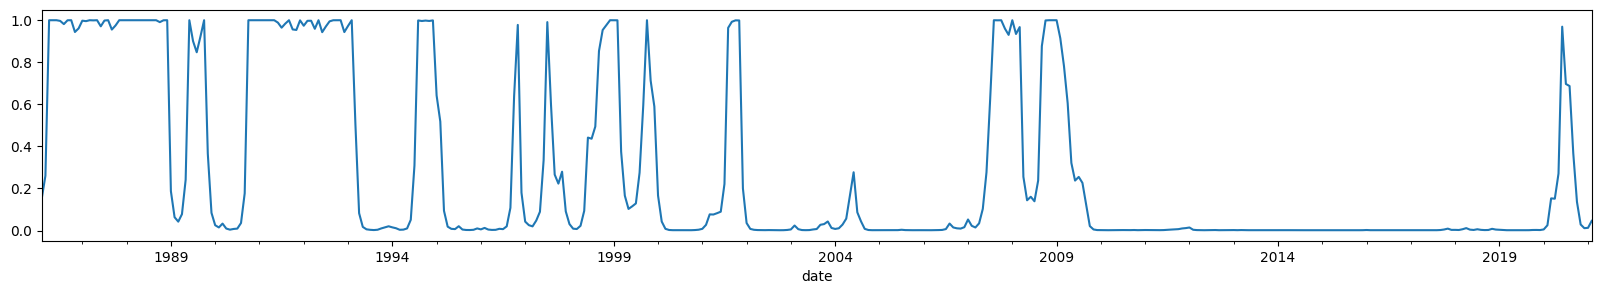

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.DataFrame(data=res.smoothed_marginal_probabilities[1])

# plot the DataFrame using pandas plot method
df.plot(figsize=(20,3), legend=False)
plt.show()

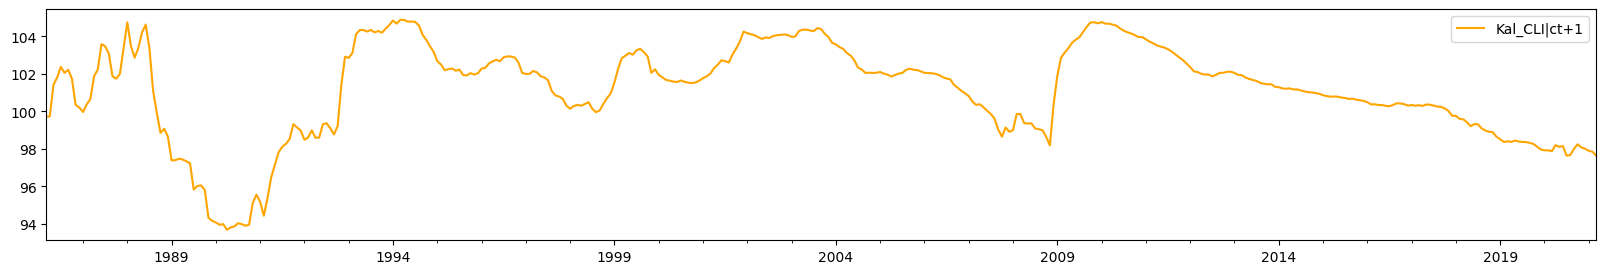

In [13]:
import numpy as np
from numpy.random import normal
N=kalpre.shape[0]
ddelta=np.mean(delta)
C0=99.72203
newCLI = np.zeros((N, 1))
iiter = 1000# iteration time, appropriate iteration is about 50000 for this project after testing.
#You can run in your own computer for proper itertaion time as it's slow in google colab
mc = np.zeros((iiter, 1))
for m in range(iiter):
    mc[m] = C0 +normal(xi[0,0], np.sqrt(V[0,0]))+ddelta#normal(xi[0,0], np.sqrt(V[0,0])) + delta
newCLI[0] = np.mean(mc)
mc = np.zeros((iiter, 1))
for i in range(1, N):
    for m in range(iiter):
        mc[m] = newCLI[i-1] + + normal(xi[0,i], np.sqrt(V[0,i]))#normal(xi[0,i], np.sqrt(V[0,i]))
    newCLI[i] = np.mean(mc) # new delta_C_t=delta_c_t+C_{t-1}+delta according to appendix A7
    # Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(10,3))
# Plot the series
series1.plot(figsize=(20,3), legend=False,label='Kal_CLI|ct+1',color='orange')


# Set the y-axis limits
#ax.set_ylim(80, 110)
plt.legend()
plt.savefig('myplot.png')
plt.show()

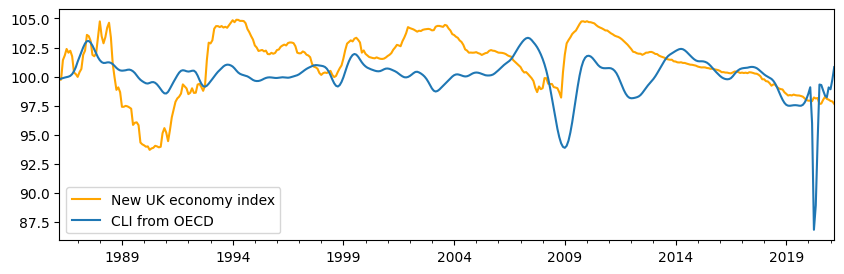

In [14]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/CLI_raw.csv'#original CLI data
CLI = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)
# Create an array of monthly dates
dates = pd.date_range(start='1986-03-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(10,3))
# Plot the series
series1.plot(figsize=(10,3), legend=False,label='New UK economy index',color='orange')

# Create another pandas Series with the same dates as index
series2 = pd.Series(CLI.values.ravel(), index=dates)
# Plot the series

# Plot the second series
series2.plot(figsize=(10,3), legend=False,label='CLI from OECD')



# Set the y-axis limits
#ax.set_ylim(80, 110)
plt.legend()
plt.savefig('myplot.png')
plt.show()

